# Salary prediction

## Data examine

> [**Statistical information**](#1)

> [**Target data**](#2)

> [**Result**](#3)

### Import modules

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline

#your info here
__author__ = "Ya Yu Chen"
__email__ = "a725761@gmail.com"

In [2]:
def load_data(file_path):
    return pd.read_csv(file_path)

In [3]:
train_features = 'C:\\Users\\EllenChen\\Desktop\\DSDJ\\case study\\HR and salary prediction example\\salaryprediction\\data\\train_features.csv'
test_features = 'C:\\Users\\EllenChen\\Desktop\\DSDJ\\case study\\HR and salary prediction example\\salaryprediction\\data\\train_features.csv'
train_target = 'C:\\Users\\EllenChen\\Desktop\\DSDJ\\case study\\HR and salary prediction example\\salaryprediction\\data\\train_salaries.csv'

train_feature_df = load_data(train_features)
test_feature_df = load_data(test_features)
train_target_df = load_data(train_target)

In [4]:
train_df = pd.merge(train_feature_df, train_target_df, how='inner', on='jobId')
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [5]:
# divide categorical and numerical features for later use
cat_feature = [i for i in train_feature_df.columns if train_feature_df[i].dtype.name == 'object' or train_feature_df[i].dtype.name == 'category']
num_feature = [i for i in train_feature_df.columns if train_feature_df[i].dtype.name == 'int64'  or train_feature_df[i].dtype.name == 'float']

<a class="anchor" id="1"></a>
### Examine statistical data information

In [6]:
#check any missing values
train_df.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

In [7]:
# check any duplicated data
train_df.duplicated().sum()

0

In [8]:
#check type of features
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [9]:
# numerical data statistical analysis
train_df.describe(include=[np.number])

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [10]:
# categorical data statistical analysis
train_df.describe(include=['O'])

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684849173,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


<a class="anchor" id="2"></a>
### Target data examine

C:\Users\EllenChen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\EllenChen\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


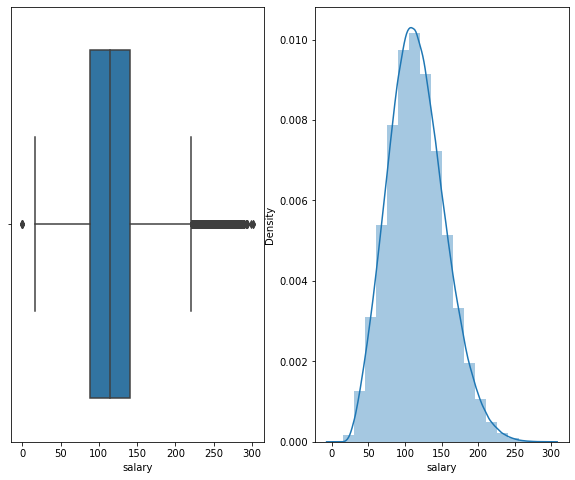

In [11]:
# plot salary's distribution and boxplot
plt.figure(figsize=(10,8))
plt.subplot(121)
sns.boxplot(train_df.salary)
plt.subplot(122)
sns.distplot(train_df.salary, bins=20)
plt.show()

**1.** From the left side of box plot, there are outliers below Q1 and above Q4 quartile range.                                         
**2.** From the right side of target distribution plot, it shown a normal distribution of salary, target mean located around 120.

In [12]:
# find out the quartile of salary and outliers
quartile = train_df.salary.describe()
IQR = quartile['75%'] - quartile['25%']
above_outlier = quartile['75%'] + IQR*1.5
lower_outlier = quartile['25%'] - IQR*1.5

In [13]:
# examine the job type above outliers above Q4
train_df[train_df['salary']>above_outlier]['jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [14]:
train_df[(train_df['salary']>above_outlier) & (train_df['jobType']=='JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


**It shows that job type as a junior in OIL, FINANCE and WEB industries, the salary is more than other industry.**

In [15]:
# data below Q1 quartile
train_df[train_df['salary']<lower_outlier]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


**In the data above, it seemed unlikely that job type as CTO, MANAGER and VICE PRESIDENT would have a 0 salary, so I would remove these unreasonable data.**

C:\Users\EllenChen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


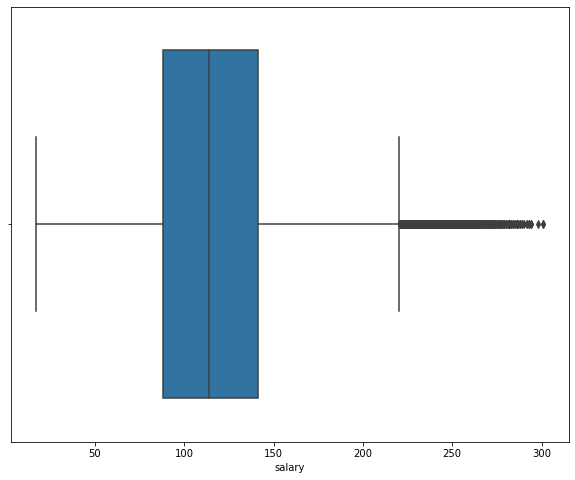

In [16]:
# remove unreliable data and determine the box plot of salary
train_df = train_df[train_df['salary']>lower_outlier]

plt.figure(figsize=(10,8))
sns.boxplot(train_df.salary)
plt.show()

In [17]:
# shuffle data
train_df = shuffle(train_df).reset_index()

In [18]:
train_df.to_csv('cleaned_shuffle_train_df.csv', sep=',', index=False)

<a class="anchor" id="3"></a>
## Result

#### From the data of outliers, it shows that salary above Q4's job type are high level or management employees, only small amount of them are junior level staff. Those low level staff with higher salary all from OIL, FINANCE and WEB industries.